## Hyperparameters

In [1]:
import os
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

print('Available devices ', torch.cuda.device_count())
print('Current cuda device ', torch.cuda.current_device())

Available devices  1
Current cuda device  0


In [2]:
import warnings
warnings.simplefilter("ignore", UserWarning)
import os
import random
import time
import glob
from tqdm import tqdm
import socket
from sklearn import preprocessing
from sklearn.svm import LinearSVC
import sys
sys.path.append('/home/dohwan/python/MIL-NCE_HowTo100M/')

import numpy as np
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from itertools import product, tee
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed

from s3dg import S3D
from args import get_args
from loader.video_loader_clip_ind import HT100M_DataLoader
from loss import MILNCELoss, CDTW
from sdtw import SoftDTW as custom_SoftDTW
from soft_dtw_cuda import SoftDTW
from dtw import DTW

from utils import AllGather
from utils import get_cosine_schedule_with_warmup

import json
from array2gif import write_gif
import matplotlib.image as mpimg
from IPython.display import Image, display
from PIL import Image
import ot
import math
train_csv = '../csv/16_videos_joonmyung.csv'
video_path = '../../data/HowTo100M/small_videos'
caption_root = '../../data/HowTo100M/small_caption_json'
min_time = 5.0
fps = 10
num_clip = 8
num_frames = 32
video_size = 224
num_candidates = 5
num_thread_reader = 20
batch_size = 2
pin_memory = False
train_sampler = None
word2vec_path = '../../data/HowTo100M/data/word2vec.pth'
def draw(matrixes, vmin=None, vmax=None, col=1, p=False, title=[], fmt=1):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    row = (len(matrixes)-1)//col+1
    annot = True if fmt>0 else False
    if p:
        print("row : {}, col : {}".format(row, col))
        print("height : {}, width : {}".format(row*8, col*8))

    
    title = title + list(range(len(title), len(matrixes)-len(title)))
    fig, axes = plt.subplots(nrows=row, ncols=col, squeeze=False)
    fig.set_size_inches(col*8, row*8)

    for e, matrix in enumerate(matrixes):
        if type(matrix) == torch.Tensor:
            matrix = matrix.detach().cpu().numpy()
        elif matrix == None:
            continue
        ax = axes[e//col][e%col]
        sns.heatmap(pd.DataFrame(matrix), annot=annot, fmt=".{}f".format(fmt), cmap='Greys'
                        , yticklabels=False, xticklabels=False, vmin=vmin, vmax=vmax
                        , linewidths=.1, linecolor='black'
                        , ax=ax)

        ax.set(title=title[e])
    plt.show()
    
def dot_product(x, y):
    z = torch.matmul(x, y.transpose(1, 2))
    z.requires_grad = True
    return -z

def validation(i, minimum = 0, maximum = 8):
    return True if (minimum <= i and i < maximum) else False    
    
def minGamma(matrix, i, j, r=8, c=8, gamma=0.1, p=False):
    if i == 0 and j == 0:
        return torch.tensor([0], device=torch.device("cuda"))
    
    if validation(i-1, maximum=r) and validation(j-1, maximum=c):
        a, b, c = -matrix[:, i-1, j]/gamma, -matrix[:, i, j-1]/gamma, -matrix[:, i-1, j-1]/gamma
        res = torch.log(torch.exp(a) + torch.exp(b) + torch.exp(c))
    elif validation(i-1, maximum=r):
        res = -matrix[:, i-1, j] / gamma
    elif validation(j-1, maximum=c):
        res = -matrix[:, i, j-1] / gamma
    else:
        False
    if p: print("val : {}".format(-gamma*res))
    return -gamma * res

def dtw(cost, r=8, c=8, gamma=0.01):
    tc = torch.ones_like(cost).double().cuda()
    for i in range(0, r):
        for j in range(0, c):
            tc[:, i, j] = minGamma(tc, i, j, r=r, c=c, gamma=gamma) + cost[:, i, j]
    return tc

def getGradient(loss, matrix):
    return torch.autograd.grad(loss, matrix, retain_graph=True)[0].cpu().detach().squeeze(0)

def softmin(m, t=0, dim=0, gamma=1):
    softV = torch.exp(-m/gamma)/torch.exp(-m/gamma).sum(dim=dim).unsqueeze(dim=dim)
    if t == 1:
        for i in range(len(softV)):
            softV[i] /= softV[i,i].item()
    return softV

## Dataloader & Model

In [3]:
crop_only = 1 # 뭔지는 모르겠는데 하는게 Augmentation을 뺼 수 있을 것 같은 느낌적인 느낌..?
centercrop = 1  # 0: random crop, 1 : center crop
random_flip = 0 # 0: None,        1 : random flip

########################################################################
pretrain_cnn_type = 0 # 0 : Ours, 1 : MIL-NCE
[pretrain_cnn_path, STD] = ['./checkpoint/s3d_howto100m.pth', True] if pretrain_cnn_type == 1 else ['./checkpoint/ours/3.pth.tar', False]

checkpoint = torch.load(pretrain_cnn_path)
model = S3D(512, space_to_depth=STD, word2vec_path=word2vec_path)
if pretrain_cnn_type: # MIL-NCE
    model.load_state_dict(checkpoint)
    model = torch.nn.DataParallel(model)
else: # Ours
    model = torch.nn.DataParallel(model)
    model.load_state_dict(checkpoint["state_dict"])
model = model.cuda()


train_dataset = HT100M_DataLoader(
    csv=train_csv,
    video_root=video_path,
    caption_root=caption_root,
    min_time=min_time,
    fps=fps,
    num_frames=num_frames,
    size=video_size,
    crop_only=crop_only,
    center_crop=centercrop,
    random_left_right_flip=random_flip,
    num_candidates=num_candidates,
    analysis_idx = 42
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1,
#     batch_size=len(pd.read_csv("./csv/16_videos_joonmyung.csv")["video_path"]),
    shuffle=False,
    drop_last=True,
    num_workers=num_thread_reader,
    pin_memory=pin_memory,
    sampler=train_sampler,
)

# criterion = DTW(use_cuda=True)
def getAnalysisInfo(video_id, text_raw, ind_list, duration):
    return [{"video_id":video_id,
            "link": "https://www.youtube.com/embed/{}?start={}&end={}".format(video_id[0],duration[i][0].numpy()[0],int(duration[i][1].numpy()[0])),
             "text":text_raw[i],
             "ind":ind_list[i],
             "duration":[duration[i][0].numpy()[0], duration[i][1].numpy()[0]]
           } for i in range(len(text_raw))]

videoInfo = []
visuals, texts = [], []
with torch.no_grad():
    for data in tqdm(train_loader):
        visual = data['video'].detach().squeeze(0).float().cuda(0) / 255.
        text = data['text'].detach().squeeze(0).long().cuda(0)
        visual_embd, text_embd = model(visual, text)
        videoInfo.append(
                {"visual_embd":F.normalize(visual_embd).view(-1, num_clip, visual_embd.shape[1])
                 , "text_embd":F.normalize(text_embd).view(-1, num_clip, text_embd.shape[1])
                 , "analysisInfo":getAnalysisInfo(data['video_id'], data['text_raw'], data['ind_list'], data['duration'])
                 , "text":data['text_raw']})
        
        
del(model)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/it]


In [4]:
## Pretext
# pre_word_raws = ["write your dog's name on the nameplate" ,"color print" ,"add your own designs" ,"add the entire doghouse" ,"color the dog house"]
#                             # 0-1                                2                  4                         5                        6        
# pre_word_embd = []
# for pre_word_raw in pre_word_raws:
#     pre_word_embd.append(train_dataset.words_to_ids(pre_word_raw))
# pre_word_embd = torch.stack(pre_word_embd)
# with torch.no_grad():
#     visual_embd_pre, text_embd_pre = model(visual, pre_word_embd)

# visual_embd_pre = F.normalize(visual_embd_pre).view(-1, 8, visual_embd_pre.shape[1])
# text_embd_pre = F.normalize(text_embd_pre).view(-1, 5, text_embd_pre.shape[1])
# def dot_product(x, y):
#     z = torch.matmul(x, y.transpose(1, 2))
#     z.requires_grad = True
#     return -z

# Ds = []
# D = dot_product(visual_embd_pre, text_embd_pre).squeeze(0).detach().cpu().numpy()
# Dv = dot_product(visual_embd_pre, visual_embd_pre).squeeze(0).detach().cpu().numpy()
# Dt = dot_product(text_embd_pre, text_embd_pre).squeeze(0).detach().cpu().numpy()
# Ds.append(D)
# Ds.append(Dv)
# Ds.append(Dt)

## Pair-Wise Distance

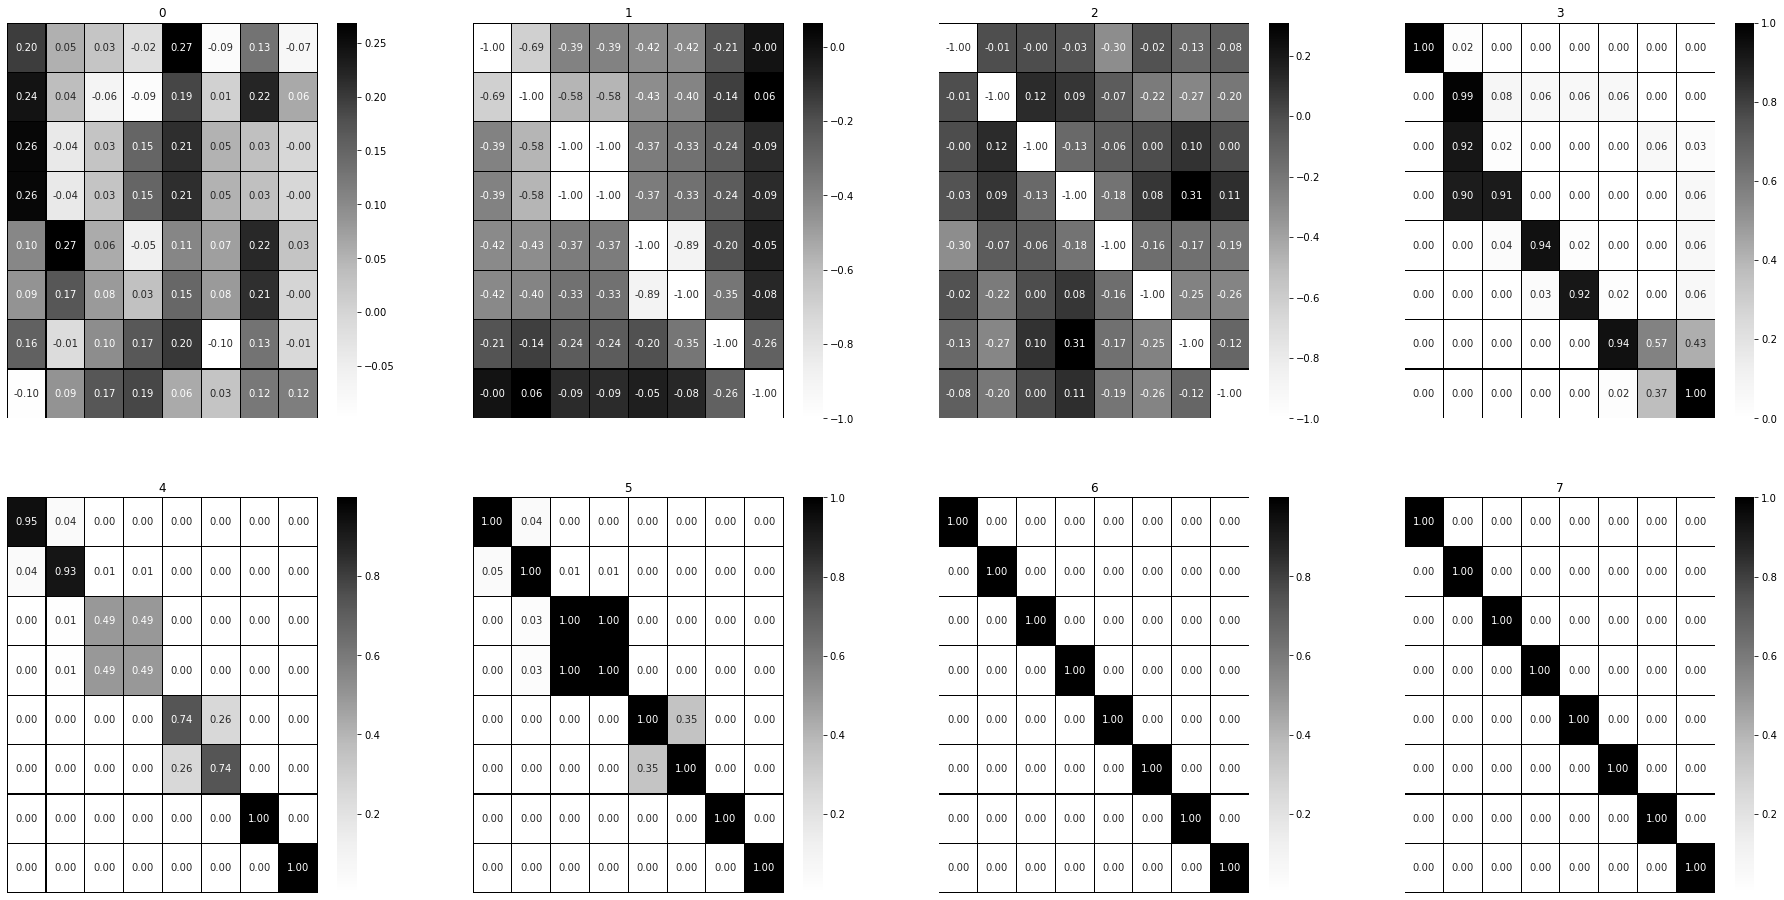

[('to cross and 1:06 when to hang',), ('that phillip force between my tasks',), ('nmsh buns',), ('for set fire like a lamb from highway to when',), ('this time about cancer',), ("if she's codes in misha my turn is not",), ('change the solution with a white goal broke and',), ('the expense of no one selling salon',)]


In [5]:
Ds = []
row, col, gammaC = 8, 8, 0.1
for e, info in enumerate(videoInfo):
    D = dot_product(info["visual_embd"], info["text_embd"])
    Dv = dot_product(info["visual_embd"], info["visual_embd"])
    Dt = dot_product(info["text_embd"], info["text_embd"])    
    tc = dtw(D, gamma = 0.01)
    E = getGradient(tc[:, row-1, col-1], D)
    
    Ds.append(D[0])
    Ds.append(Dv[0])
    Ds.append(Dt[0])
    Ds.append(E)
    Ds.append(softmin(Dv[0], t=0, gamma=gammaC, dim=0))
    Ds.append(softmin(Dv[0], t=1, gamma=gammaC, dim=0))
    Ds.append(softmin(Dt[0], t=0, gamma=gammaC, dim=1))
    Ds.append(softmin(Dt[0], t=1, gamma=gammaC, dim=1))
    
    
analysis_num = 0
draw([Ds[i] for i in range(analysis_num*8,(analysis_num+1)*8)], col=4, fmt=2)


# print(videoInfo[analysis_num]['analysisInfo'])
print(videoInfo[analysis_num]['text'])

## DTW (+) vs (-)

min : 0.0 , max : 0.3


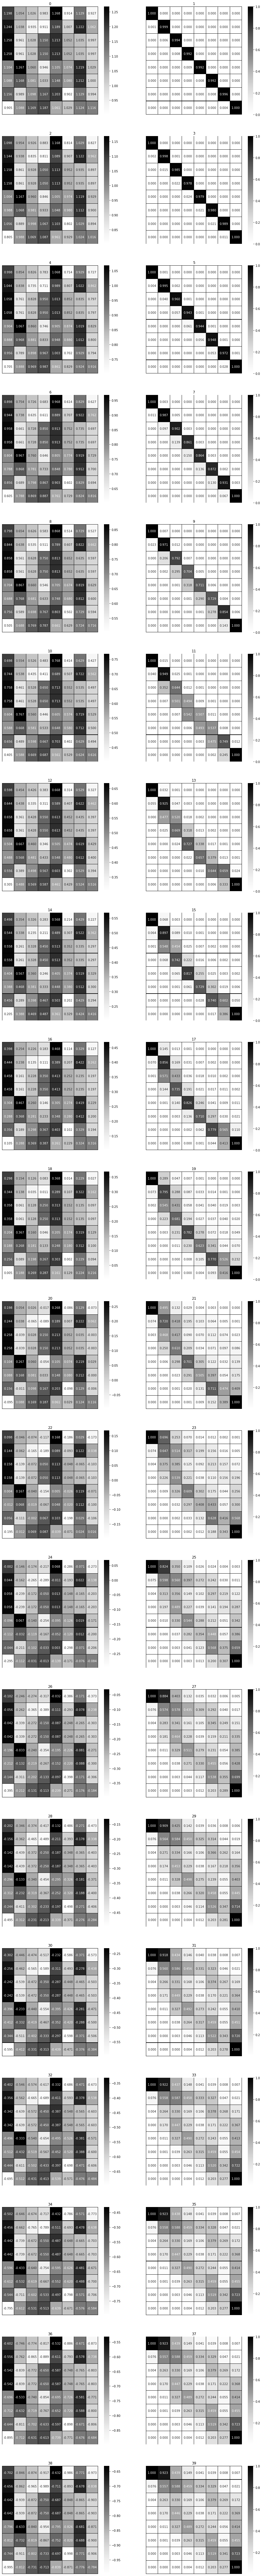

In [6]:
cost = dot_product(info["visual_embd"], info["text_embd"])
dot = math.pow(10,1)
minVal = int(math.ceil(cost.min()*dot))/dot
maxVal = int(math.ceil(cost.max()*dot))/dot
print("min : {} , max : {}".format(minVal, maxVal))
result = []
# for i in np.arange(minVal, maxVal, 0.1):
for i in np.arange(-1, 1, 0.1):
    cost = dot_product(info["visual_embd"], info["text_embd"]) - i
    tc = dtw(cost, gamma = 0.1)
    EB = getGradient(tc[:, row-1, col-1], cost)
    result += [cost[0], EB]

    
draw(result, col=2, fmt=3)

## DTW Ours

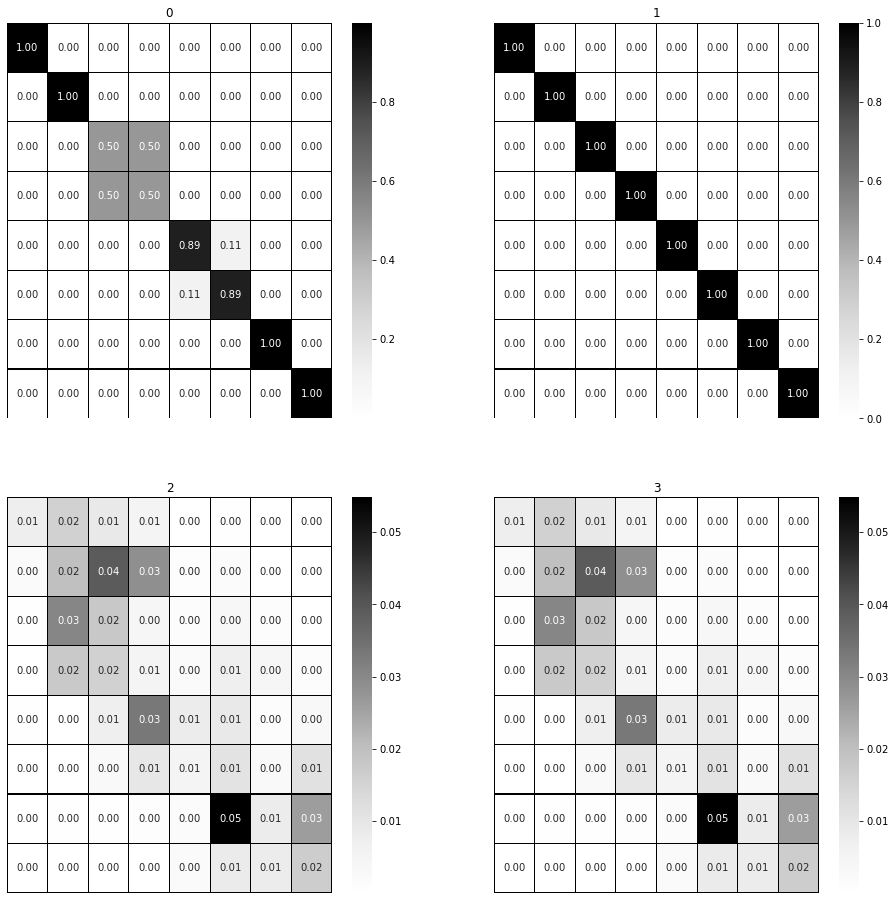

In [7]:
# 1. Setting
gamma, gammaC, t, crw = 0.1, 0.05, 0, [False, True]
cost = dot_product(info["visual_embd"], info["text_embd"])
costV = dot_product(info["visual_embd"], info["visual_embd"])
costT = dot_product(info["text_embd"], info["text_embd"])
_, r, c = cost.shape

# 2. BaseLine
# cumB = dtw(cost, gamma=gamma, r=r, c=c)
# GB = getGradient(cumB[:, -1, -1], cost)

# draw([cost[0], GB], col=2, fmt=1)
# print("-" * 150)

# 3. Add Padding
cost_pad = torch.ones([1,r*2+1,c*2+1], device=torch.device("cuda")) * min(cost.mean().detach(), -0.3)
cost_pad[:,1::2,1::2] = cost[:]

cum = dtw(cost_pad, gamma=gamma, r=r*2+1, c=c*2+1)
G = getGradient(cum[:, -1, -1], cost)
GP = getGradient(cum[:,-1, -1], cost_pad)

# draw([cost[0], cost_pad[0], GB, None, G, GP], col=2, fmt=1) # GP
# print("-" * 150)

# 4-1. Cost Clustering(CostV, CostC)
softV = softmin(costV[0], t=t, gamma=gammaC, dim=0)
softT = softmin(costT[0], t=t, gamma=gammaC, dim=1)

GC = torch.zeros_like(G).double().cuda()
for i in range(0, r):
    for j in range(0, c):
        if crw[0]: GC[::, j] += G[i, j] * softV[:, i]
        if crw[1]: GC[i, ::] += G[i, j] * softT[j]
GC /= sum(crw)
draw([softV, softT, G, GC], col=2, fmt=2)


# # 4-2. Cost Clustering(Cost)
# softC = softmin(cost[0], t=t, gamma=gammaC, dim=0)
# softR = softmin(cost[0], t=t, gamma=gammaC, dim=1)

# GC = torch.zeros_like(G).double().cuda()
# for i in range(0, r):
#     for j in range(0, c):
#         if crw[0]: GC[::, j] += G[i, j] * softC[:, i]
#         if crw[1]: GC[i, ::] += G[i, j] * softR[j]
# GC /= sum(crw)
# draw([softC, softR, G, GC], col=2, fmt=2)




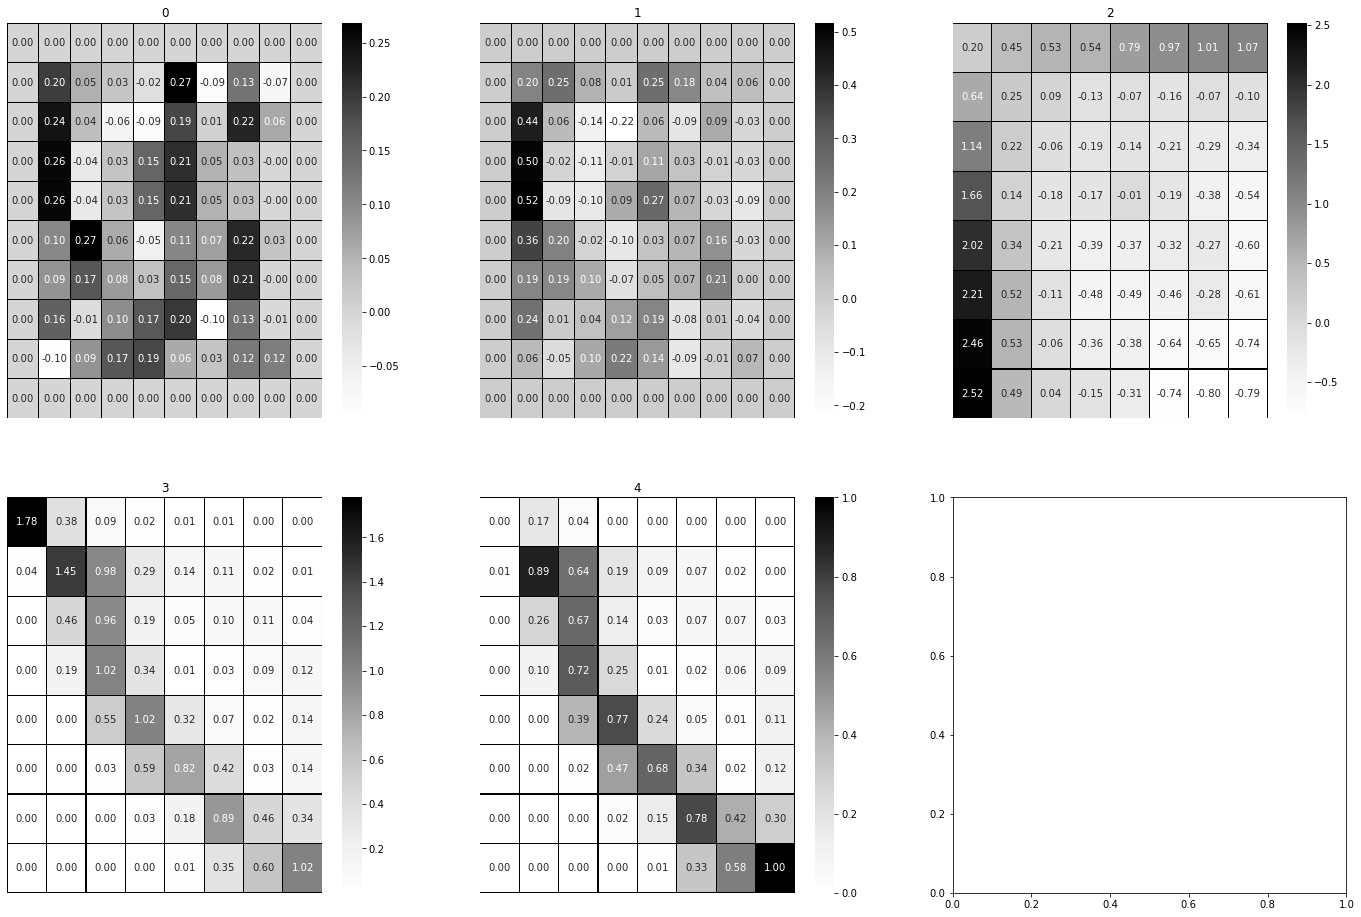

In [79]:
import math
import torch.nn as nn
def smoothing(cost1, gamma):
    a1 = torch.ones((cost1.shape[0], cost1.shape[1] + 1, cost1.shape[2] + 1)).cuda() * math.inf
    a2 = torch.ones((cost1.shape[0], cost1.shape[1] + 1, cost1.shape[2] + 1)).cuda() * math.inf
    a3 = torch.ones((cost1.shape[0], cost1.shape[1] + 1, cost1.shape[2] + 1)).cuda() * math.inf
    a1[:, :8, 1:9] = cost1
    a2[:, 1:9, :8] = cost1
    a3[:, 1:9, 1:9] = cost1
    a1[:, 0, 0] = 0
    a2[:, 0, 0] = 0
    a3[:, 0, 0] = 0
    gamma = 1e-1
    cost2 = -gamma * torch.log(torch.exp(-a1 / gamma) + torch.exp(-a2 / gamma) + torch.exp(-a3 / gamma))
    smoothed = torch.zeros((cost2.shape[0], cost2.shape[1] + 1, cost2.shape[2] + 1)).cuda()
#     smoothed[:, 1:, 1:] = cost2
    smoothed = cost2[:, :8, :8]
    return smoothed

def padding(m, type):
    if type == 'zero':
        pad = torch.zeros((m.shape[0], m.shape[1]+2, m.shape[2]+2)).cuda()
    elif type == '-inf':
        pad = torch.ones((m.shape[0], m.shape[1]+2, m.shape[2]+2)).cuda() * -math.inf
    pad[:, 1:m.shape[1]+1, 1:m.shape[2]+1] = m
    return pad

def validation(i, minimum = 0, maximum = 8):
    return True if (minimum <= i and i < maximum) else False    

def minGamma(cost, i, j, gamma=0.1, p=False):
    a = cost[:, i-1, j]
    b = cost[:, i, j-1]
    c = cost[:, i-1, j-1]
    
    a = - (a) / gamma
    b = - (b) / gamma
    c = - (c) / gamma
    res = torch.log(torch.exp(a) + torch.exp(b) + torch.exp(c))
    return -gamma * res

gamma = 0.1
D = dot_product(info["visual_embd"], info["text_embd"])
# D_pad = padding(D)
# D_hat = smoothing(D, gamma) + D
# D_pad = padding(D, type='zero')
# D_hat_pad = padding(D_hat, type='zero')
# draw([D[0], D_pad[0], D_hat[0]], col = 3, fmt=2)                             

R = torch.ones_like(D_pad).double().cuda() * math.inf
R[:, 0, 0] = 0

# D_hat_pad = torch.zeros_like(D_pad).cuda()
# for i in range(1, 10):
#     for j in range(1, 10):
#         D_hat_pad[:, i, j] = minGamma(D_pad, i, j, gamma=gamma) + D_pad[:, i, j]

tc[:, 0, 0] = D[:, 0, 0]
D_hat[:, 0, 0] = D[:, 0, 0]
for i in range(1, 8):
    D_hat[:, i, 0] = D[:, i-1, 0] + D[:, i, 0]
for j in range(1, 8):
    D_hat[:, 0, j] = D[:, 0, j-1] + D[:, 0, j]
for i in range(1, 8):
    for j in range(1, 8):
        D_hat[:, i, j] = minGamma(D, i, j) + D[:, i, j]
D_pad = padding(D, type='zero')
D_hat_pad = padding(D_hat, type='zero')

for i in range(1, 8):
    tc[:, i, 0] = tc[:, i-1, 0] + D_hat[:, i, 0]
for j in range(1, 8):
    tc[:, 0, j] = tc[:, 0, j-1] + D_hat[:, 0, j]
for i in range(1, 8):
    for j in range(1, 8):
        tc[:, i, j] = minGamma(tc, i, j) + D_hat[:, i, j]
l = tc[:, row-1, col-1]
R[:, 1:9, 1:9] = tc
        
        

# for i in range(1, 9):
#     for j in range(1, 9):
# #         R[:, i, j] = minGamma(R, i, j, gamma=gamma) + D_hat[:, i-1, j-1]
#         R[:, i, j] = minGamma(R, i, j, gamma=gamma) + D_hat_pad[:, i, j]
# #         R[:, i, j] = minGamma(R, i, j, gamma=gamma) + D_pad[:, i, j]

R[:, -1, :] = -math.inf
R[:, :, -1] = -math.inf
R[:, -1, -1] = R[:, -2, -2]

E = torch.zeros_like(D_pad).cuda()
E[:, -1, -1] = 1

# mu = torch.autograd.grad(D_hat[:, 4, 4], D, retain_graph=True)[0].cpu().detach()
# mu = torch.autograd.grad(R[:, 4, 4], D_hat, retain_graph=True)[0].cpu().detach()
# print(mu)

    
for i in range(8,0,-1):
    for j in range(8,0,-1):
#         mu = torch.autograd.grad(R[:, i, j], D_hat, retain_graph=True)[0].cpu().detach()[:, i-1, j-1]
#         mu = torch.autograd.grad(D_hat_pad[:, i, j], D_pad, retain_graph=True)[0].cpu().detach()
#         print(mu)
         
        if i == 18:
            _a = 0
        else:
            _a = math.exp((D_hat_pad[:, i + 1, j    ] - D_pad[:, i, j] - D_pad[:, i + 1, j    ]) / gamma)
        if j == 18:
            _b = 0
        else:
            _b = math.exp((D_hat_pad[:, i    , j + 1] - D_pad[:, i, j] - D_pad[:, i    , j + 1]) / gamma) 
        if i == 18 or j == 18:
            _c = 0
        else:
            _c = math.exp((D_hat_pad[:, i + 1, j + 1] - D_pad[:, i, j] - D_pad[:, i + 1, j + 1]) / gamma)
        
        a = (math.exp((R[:, i + 1 , j    ] - R[:, i, j] - D_hat_pad[:, i + 1, j    ]) / gamma)) + _a /20
        b = (math.exp((R[:, i     , j + 1] - R[:, i, j] - D_hat_pad[:, i    , j + 1]) / gamma)) + _b /20
        c = (math.exp((R[:, i + 1 , j + 1] - R[:, i, j] - D_hat_pad[:, i + 1, j + 1]) / gamma)) + _c /20
            
    
#         a = math.exp((D_hat_pad[:, i + 1, j    ] - D_pad[:, i, j] - D_pad[:, i + 1, j    ]) / gamma)
#         b = math.exp((D_hat_pad[:, i    , j + 1] - D_pad[:, i, j] - D_pad[:, i    , j + 1]) / gamma)
#         c = math.exp((D_hat_pad[:, i + 1, j + 1] - D_pad[:, i, j] - D_pad[:, i + 1, j + 1]) / gamma)

#         a = math.exp((R[:, i + 1 , j    ] - R[:, i, j] - D_pad[:, i + 1, j    ]) / gamma)
#         b = math.exp((R[:, i     , j + 1] - R[:, i, j] - D_pad[:, i    , j + 1]) / gamma)
#         c = math.exp((R[:, i + 1 , j + 1] - R[:, i, j] - D_pad[:, i + 1, j + 1]) / gamma)
#         print(i, j, (R[:, i + 1 , j    ] - R[:, i, j] - D_hat_pad[:, i + 1, j    ]).item(), (D_hat_pad[:, i + 1, j    ] - D_pad[:, i, j] - D_pad[:, i + 1, j    ]).item())
#         print(D_hat_pad[:, i + 1, j    ].item(), D_pad[:, i, j].item(), D_pad[:, i + 1, j    ].item())
#         print(i, j, a, b, c)
#         print(R[:, i + 1 , j + 1].item(), R[:, i, j].item(), D_hat_pad[:, i + 1, j + 1].item())
#         print(math.exp((D_hat_pad[:, i + 1, j + 1] - D_pad[:, i, j] - D_pad[:, i + 1, j + 1]) / gamma) )
        E[:, i, j] = E[:, i + 1, j] * a + E[:, i, j + 1] * b + E[:, i + 1, j + 1] * c

    

E_r = torch.autograd.grad(l, D_hat, retain_graph=True)[0].cpu().detach()

draw([D_pad[0], D_hat_pad[0], R[0, 1:9, 1:9], E[0, 1:9, 1:9], E_r[0]], col = 3, fmt=2)
# draw([D[0], D_hat[0], R[0], E[0]], col = 3, fmt=3)


## Toy Example

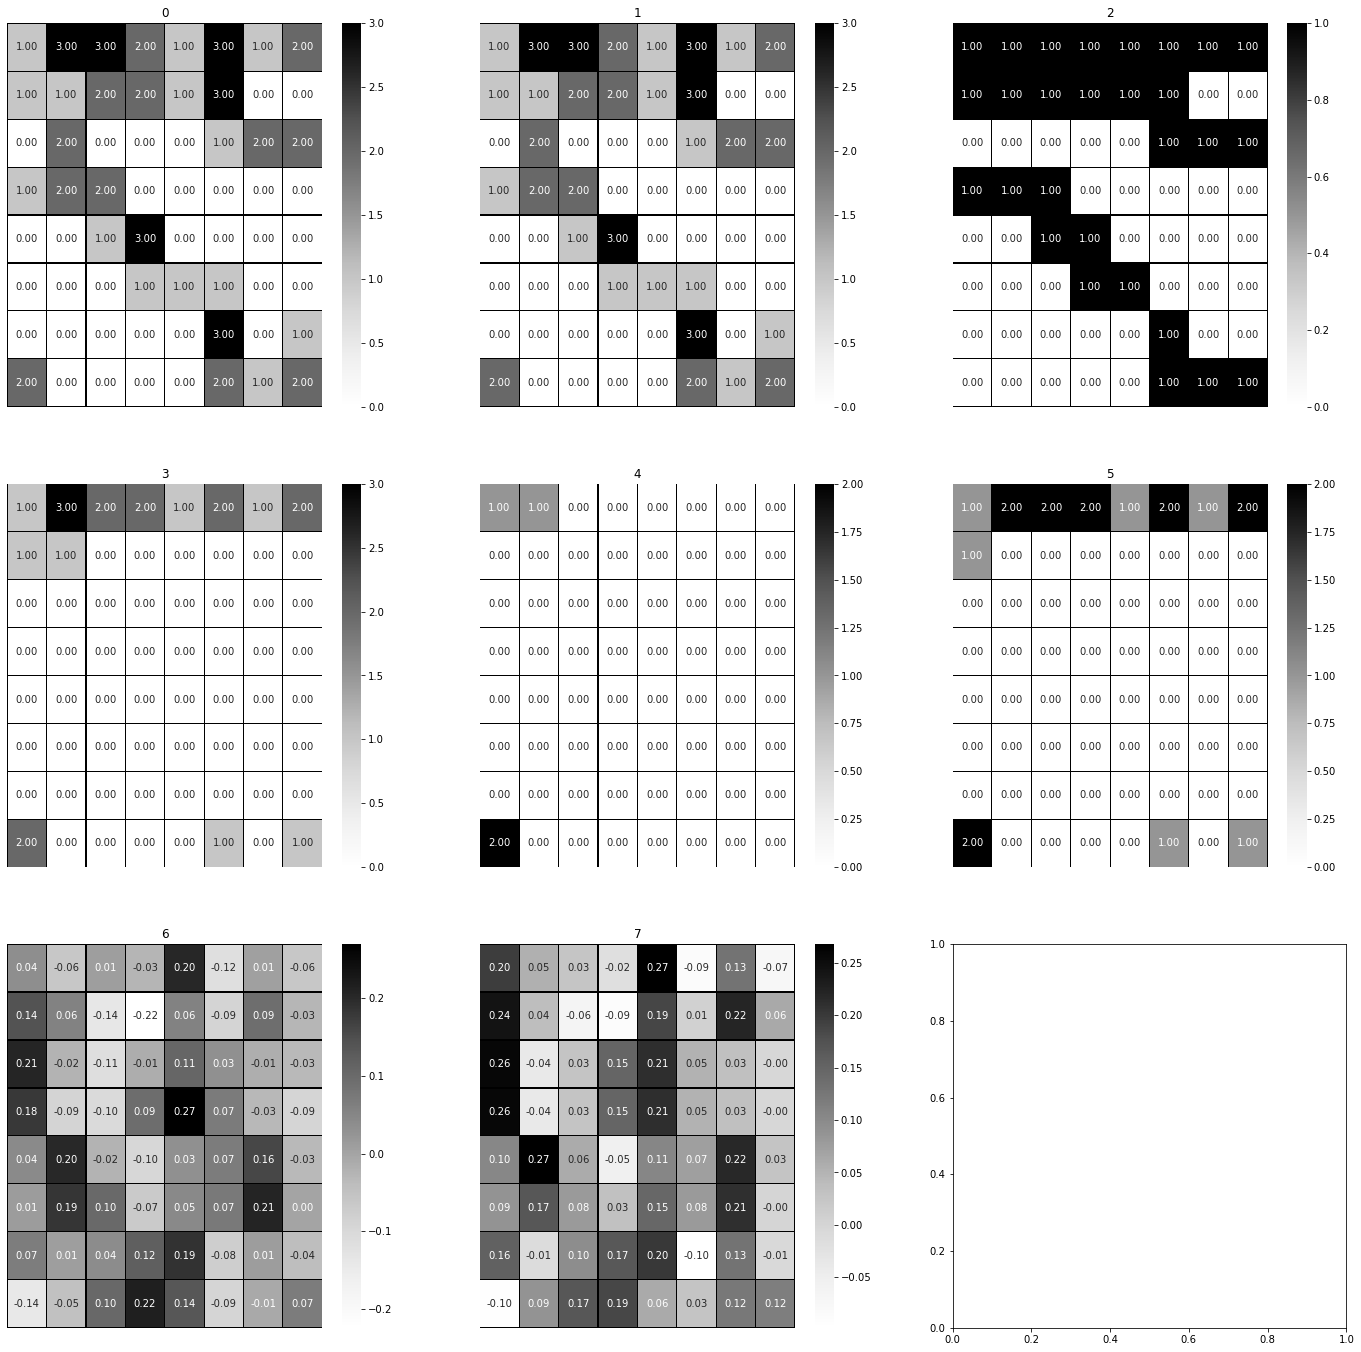

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def dtw_typeA(cost, row=8, col=8, gamma=0.05):
    tc = torch.ones_like(cost).double().cuda()
    for i in range(0, row):
        for j in range(0, col):
            tc[:, i, j] = minGamma(tc, i, j, gamma=gamma) + minGamma(cost, i, j, gamma=gamma) + cost[:, i, j]
    return tc

import copy
def dtw_typeB(cost, row=8, col=8, gamma=0.05):
    costB = torch.ones_like(cost).double().cuda()
    tc = torch.ones_like(cost).double().cuda()

    for i in range(0, row):
        for j in range(0, col):
            costB[:,i,j] = minGamma(cost, i, j, gamma=gamma) + cost[:,i,j]
    for i in range(0, row):
        for j in range(0, col):
            tc[:, i, j] = minGamma(tc, i, j, gamma=gamma) + costB[:, i, j]
    return tc, costB


# # costA = torch.tensor(
#         [[[0.1, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.8, 0.1, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.8, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.9, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.9, 0.9, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.9, 0.9, 0.5, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.9, 0.9, 0.9, 0.2, 0.4, 0.3, 0.9, 0.9]
#          , [0.9, 0.9, 0.8, 0.9, 0.2, 0.4, 0.3, 0.2]]]
#         , device=torch.device("cuda"), requires_grad=True)
# costB = torch.tensor(
#         [[[0.1, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.8, 0.1, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.8, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.9, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.9, 0.9, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.9, 0.9, 0.5, 0.9, 0.9, 0.9, 0.9, 0.9]
#          , [0.9, 0.9, 0.9, 0.2, 0.4, 0.3, 0.9, 0.9]
#          , [0.9, 0.9, 0.8, 0.9, 0.2, 0.4, 0.3, 0.2]]]
#         , device=torch.device("cuda"), requires_grad=True)
# costB = copy.deepcopy(costA)



costA = dot_product(info["visual_embd"], info["text_embd"])
costB = dot_product(info["visual_embd"], info["text_embd"])
costC = dot_product(info["visual_embd"], info["text_embd"])

cumM_A = dtw_typeA(costA, 8, 8, gamma=0.1)
EA = getGradient(cumM_A[:, row-1, col-1], costA)

cumM_B, costM_B = dtw_typeB(costB, 8, 8, gamma=0.1)
EB   = getGradient(cumM_B[:, row-1, col-1], costB)
EB_2 = getGradient(cumM_B[:, row-1, col-1], costM_B)
EB_2_1 = getGradient(cumM_B[:, 1, 1], costB)
EB_2_2 = getGradient(cumM_B[:, 0, 1], costB)
EB_2_3 = getGradient(cumM_B[:, 1, 0], costB)

# cumM_C = dtw(costC, 8, 8, gamma=0.1)
# EC = getGradient(cumM_C[:, row-1, col-1], costC)

draw([EA, EB, EB_2, EB_2_1, EB_2_2, EB_2_3, costM_B[0], costA[0]], col = 3, fmt=2)
# 0.02 * 2 + 0.36 * 2.62 + 0.98 * 2 = 2.943
# 0.02 * 1 + 0.36 * 1.62 + 0.93 * 1 = 1.5332

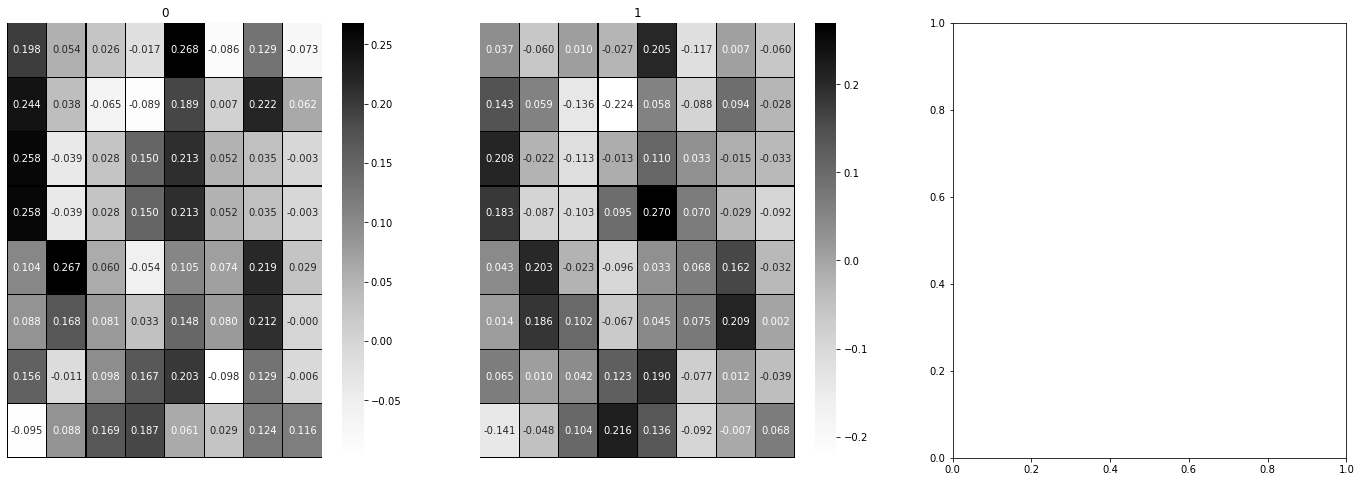

In [10]:
def smoothing(D, gamma):
    D_soft = torch.ones_like(D).double().cuda()
    b, r, c = D.shape

    for i in range(0, r):
        for j in range(0, c):
            D_soft[:, i, j] = minGamma(D, i, j, gamma=gamma) + D[:, i, j]
    return D_soft

costA = dot_product(info["visual_embd"], info["text_embd"])
costA_s = smoothing(costA, 0.1)
draw([costA[0], costA_s[0]], col = 3, fmt=3)

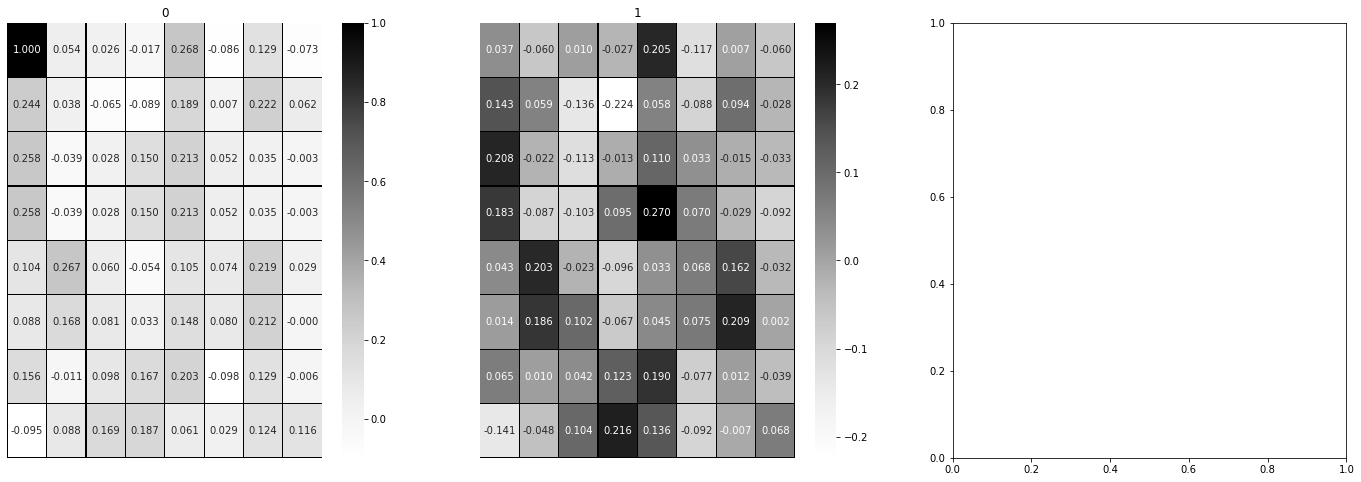

In [11]:
costA[0,0,0] = 1
draw([costA[0], costA_s[0]], col = 3, fmt=3)

## Raw Data

In [12]:
video_dict = {}
for _, data in enumerate(train_loader):
    video_id = data['video_id'][0]
    ind_list = data['ind_list']
    video_dict[video_id] = [ind.item() for ind in ind_list]
    videos = data['video']
    videos = videos.squeeze(0).permute(0,2,3,4,1).numpy()
    with open(f'/home/dohwan/data/HowTo100M/small_caption_json/{video_id}.json', 'r') as file:
        json_data = json.load(file)
        i = 0
        for clips in videos: # 8 clips of 1 video
            clips = clips.astype(np.uint8)
            frames = [Image.fromarray(clip) for clip in clips]
            frames[0].save(f'/home/dohwan/data/HowTo100M/gifs/{video_id}_{ind_list[i].item()}.gif', save_all=True, append_images=frames[1:], duration=50, loop=0)
            i += 1
        print(video_id)

5pmTIsPaX2A


In [13]:
def show_gif_caption(video_id, clip_index):
    with open(f'/home/dohwan/data/HowTo100M/small_caption_json/{video_id}.json', 'r') as file:
        json_data = json.load(file)
        display(Image.open(f'/home/dohwan/data/HowTo100M/gifs/{video_id}_{clip_index}.gif'))
        print(clip_index, json_data['text'][clip_index])

In [14]:
video_id = '-8JL1KlQDTY'
for ind in video_dict[video_id]:
    show_gif_caption(video_id, ind)

KeyError: '-8JL1KlQDTY'

## Confusion Matrix

In [ ]:
# 1: video & video
# 2: video & caption
criterion = SoftDTW(use_cuda=True, gamma=1e-1, dist_func='negative_dot')

confusion_matrix_1 = []
confusion_matrix_2 = []

for _video, _text in tqdm(zip(video_data, text_data)):
    temp_1 = []
    temp_2 = []
    _video_embd, _ = model(_video, _text)
    _video_embd = F.normalize(_video_embd).view(-1, num_clip, _video_embd.shape[1])

    for i, (video, text) in enumerate(zip(video_data, text_data)):
        video_embd, text_embd = model(video, text)
        video_embd = F.normalize(video_embd).view(-1, num_clip, video_embd.shape[1])
        text_embd = F.normalize(text_embd).view(-1, num_clip, text_embd.shape[1])
        loss = criterion(video_embd, text_embd)
        loss.backward()
    confusion_matrix_1.append(temp_1)
    confusion_matrix_2.append(temp_2)
    

In [ ]:
confusion_matrix_1 = np.array(confusion_matrix_1)
confusion_matrix_2 = np.array(confusion_matrix_2)

plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.imshow(confusion_matrix_2, cmap='Greys')
plt.title('video & caption')
plt.xlabel('caption')
plt.ylabel('video')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(confusion_matrix_1, cmap='Greys')
plt.title('video & video')
plt.xlabel('video')
plt.ylabel('video')
plt.colorbar()

plt.show()

In [ ]:
def smin(cost, i, j):
    gamma = 1e-1
    a = cost[:, i+1, j]
    b = cost[:, i, j+1]
    c = cost[:, i+1, j+1]

    a = -a / gamma
    b = -b / gamma
    c = -c / gamma
    res = torch.log(torch.exp(a) + torch.exp(b) + torch.exp(c))
    return -gamma * res

outgoing = torch.zeros((1, 8, 8)).cuda()
cost2 = torch.zeros((1, 9, 9))
cost2[:, :8, :8] = cost
cost2[:, 8, :] = math.inf
cost2[:, :, 8] = math.inf

for i in range(0, row):
    for j in range(0, col):
        outgoing[:, i, j] = smin(cost2, i, j)
outgoing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



def draw(matrix, vmin=None, vmax=None):
    sns.heatmap(pd.DataFrame(matrix.detach().cpu().numpy()), annot=True, fmt=".1f", cmap='Greys'
                            , yticklabels=False, xticklabels=False, vmin=vmin, vmax=vmax
                            , linewidths=.1, linecolor='black')
    plt.show()
        
        
x = video_embd.detach().clone().requires_grad_(True)
y = text_embd.detach().clone().requires_grad_(True)

cost = dot_product(x, y)[0]

draw(cost)


rcost = nn.Softmax(dim=0)(cost / 1e-1)
ccost = nn.Softmax(dim=1)(cost / 1e-1)

draw(rcost)
draw(ccost)
cost = rcost + ccost

tc = torch.ones_like(cost).double().cuda() * math.inf



# E2 = torch.autograd.grad(l, cost)[0].cpu().detach().squeeze(0)
# plt.imshow(E2, cmap='Greys')
# plt.title('DTW Path')
# plt.xlabel('caption')
# plt.ylabel('clip')
# plt.colorbar()
# E2

## Optimal Transport

In [ ]:
M = [[0.1, 0.7, 0.4, 0.1],
     [0.1, 0.8, 1.9, 0.2],
     [0.1, 0.7, 0.3, 0.2],
     [0.1, 0.8, 0.4, 0.1]]

M = np.array(M)
a = nn.Softmax()(-torch.sum(torch.tensor(M), dim=1) / 1e-0)
b = nn.Softmax()(-torch.sum(torch.tensor(M), dim=0) / 1e-0)
reg = 1e-1
T = ot.sinkhorn(a, b, M, reg)

plt.figure(figsize = (10, 3))
plt.title('Transport Plan $T$')
plt.imshow(T, cmap='Greys')
plt.colorbar()
plt.show()
print(T / T.max())

## 4 by 4 Example

In [ ]:
def draw(pair_distances, title=None):
    if title: print("="*40,"  ",title, "  ", "="*40)
    row, col = 3, len(pair_distances)
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(5 * col, 5 * row))
    for e, pair_distance in enumerate(pair_distances):
        
        plt.subplot(3,col,e+1)
        plt.imshow(pair_distance, cmap='Greys', vmin=0, vmax=2)
        plt.title('single video(clip) & caption')
        plt.xlabel('caption')
        plt.ylabel('clip')
        plt.colorbar()
        temps=[]
        for i in range(len(pair_distance[0])):
            temp = []
            for j in range(len(pair_distance)):
                nominator = pair_distance[i, j] * pair_distance[i, j]
                denominator = pair_distance[i, :].min() * pair_distance[:, j].min()
                val = denominator / nominator
                temp.append(val)
            temps.append(temp)


        temps = np.array(temps)

        M = pair_distance / np.max(pair_distance)
        a = nn.Softmax()(-torch.sum(torch.tensor(M), dim=1) / 1e-0)
        b = nn.Softmax()(-torch.sum(torch.tensor(M), dim=0) / 1e-0)
        reg = 1
        T = ot.sinkhorn(a, b, M=M, reg=reg)
#         T = T / np.max(T)
#         T = ot.emd(a, b, M)
#         print(T)
            
        plt.subplot(3,col,col+e+1)
        plt.imshow(T, cmap='Greys')
        plt.title('Transport Plan $T$ for case{}'.format(e+1))
        plt.colorbar()

        plt.subplot(3,col,2*col+e+1)
        plt.imshow(M*(1/T), cmap='Greys')
        plt.title('1/T * D for case{}'.format(e+1))
        plt.colorbar()

In [ ]:
case1 = np.array([[0.1, 0.1, 0.1, 0.1]
         ,[0.1, 0.1, 0.1, 0.1]
         ,[0.1, 0.1, 0.1, 0.1]
         ,[0.1, 0.1, 0.1, 0.1]])
case2 = np.array([[1, 1, 1, 1]
         ,[1, 1, 1, 1]
         ,[1, 1, 1, 1]
         ,[1, 1, 1, 1]])

# draw([case1, case2], "1. 비슷한 분포")


case1 = np.array([[1.8, 1.8, 1.8, 1.8]
                 ,[0.1, 0.1, 0.1, 0.1]
                 ,[1.8, 1.8, 1.8, 1.8]
                 ,[1.8, 1.8, 1.8, 1.8]])

case2 = np.array([[1.8, 1.8, 0.1, 1.8]
                 ,[0.1, 0.1, 0.1, 0.1]
                 ,[1.8, 1.8, 0.1, 1.8]
                 ,[1.8, 1.8, 0.1, 1.8]])

case3 = np.array([[1.8, 1.8, 0.1, 1.8]
                 ,[1.8, 1.8, 0.1, 1.8]
                 ,[1.8, 1.8, 0.1, 1.8]
                 ,[1.8, 1.8, 0.1, 1.8]])

# draw([case1, case2, case3], "2. 대표")




dist_shape = (9, 9)
dist_num = 3
dist_1 = [np.clip(np.random.normal(pair_distance_1.mean(), pair_distance_1.std(), dist_shape), a_min = 0.0, a_max= 2.0) for _ in range(dist_num)]
print("dist_1 > min : {:.4f}, max : {:.4f}, mean : {:.4f}, std : {:.4f}".format(
                        pair_distance_1.min()
                        , pair_distance_1.max()
                        , pair_distance_1.mean()
                        , pair_distance_1.std()))
dist_2 = [np.clip(np.random.normal(pair_distance_2.mean(), pair_distance_2.std(), dist_shape), a_min = 0.0, a_max= 2.0) for _ in range(dist_num)]
print("dist_2 > min : {:.4f}, max : {:.4f}, mean : {:.4f}, std : {:.4f}".format(
                        pair_distance_2.min()
                        , pair_distance_2.max()
                        , pair_distance_2.mean()
                        , pair_distance_2.std()))

# draw(dist_1+dist_2, "3. Similar with Distance Case")


cases = [np.random.randn(*dist_shape) for _ in range(dist_num)]
draw(cases, "4. Random Standard Deviation")



In [ ]:
test = torch.Tensor(
        [[0.9, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
         , [0.8, 0.8, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
         , [0.8, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
         , [0.1, 0.1, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
         , [0.9, 0.9, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
         , [0.9, 0.9, 0.1, 0.9, 0.9, 0.9, 0.9, 0.9]
         , [0.9, 0.9, 0.3, 0.4, 0.9, 0.9, 0.9, 0.9]
         , [0.9, 0.9, 0.8, 0.1, 0.2, 0.4, 0.3, 0.2]]
        
        )

print(test)
print(nn.Softmax(dim=1)(test))
print(nn.Softmax(dim=2)(test))

print("-"*100)
test = torch.Tensor(
        [[0.5, 0.4, 0.3, 0.2], [0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1], [0.1, 0.1, 0.1, 0.1]]
        )

print(test)
print(nn.Softmax(dim=0)(test))

import math
print(math.pow(math.e,5) / (math.pow(math.e,5)+math.e+math.e+math.e))
print(math.pow(math.e,1) / (math.pow(math.e,5)+math.e+math.e+math.e))
print(math.pow(math.e,1) / (math.pow(math.e,5)+math.e+math.e+math.e))
print(math.pow(math.e,1) / (math.pow(math.e,5)+math.e+math.e+math.e))

In [ ]:
def softmin_v2(m, dim=0, gamma=1):
    with torch.no_grad():
        softV = torch.exp(-m/gamma)/torch.exp(-m/gamma).sum(dim=dim).unsqueeze(dim=dim)
        for i in range(len(softV)):
            softV[i] /= softV[i,i].item()
    return softV
gamma = 0.1
costV = dot_product(info["visual_embd"], info["visual_embd"])
softV = softmin_v2(costV[0], gamma=0.1, dim=1)

draw([softV], fmt=3)

In [ ]:
softV[i,i].item()

In [ ]:
def softmin(m, dim=0, gamma=1):
    return torch.exp(-m/gamma)/torch.exp(-m/gamma).sum(dim=dim).unsqueeze(dim=dim)

gamma = 0.1

cost = dot_product(info["visual_embd"], info["text_embd"])
tc = dtw(cost, gamma = gamma)
EB = getGradient(tc[:, row-1, col-1], cost)

costV = dot_product(info["visual_embd"], info["visual_embd"])
draw([costV[0], softmin(costV[0], gamma=gamma, dim=0), softmin(costV[0], gamma=gamma, dim=1), cost[0],EB], col=3, fmt=2)

# costT = dot_product(info["text_embd"], info["text_embd"])
# draw([costT[0], softmin(costT[0], gamma=0.1, dim=0), softmin(costT[0], gamma=0.1, dim=1)], col=2)

costV = dot_product(info["visual_embd"], info["visual_embd"])
softV = softmin(costV[0], gamma=0.05, dim=0)


costT = dot_product(info["text_embd"], info["text_embd"])
softT = softmin(costT[0], gamma=0.05, dim=0)
softT[1,5] = 0.1
softT[2,5] = 0.2
softT[3,5] = 0.3
softT[4,5] = 0.3
softT[5,5] = 0.4


tc = dtw(cost, gamma = gamma)
G = torch.tensor([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                 ,[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                 ,[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                 ,[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
                 ,[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
                 ,[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
                 ,[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]
                 ,[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]])
tc_cluster = torch.zeros_like(cost).double().cuda()


for i in range(0, 8):
    for j in range(0, 8):
        tc_cluster[:, i, ::] += G[i, j] * softT[j]


draw([G, tc_cluster[0], softT], col=2)
